In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
def is_running_on_kaggle():
    return "KAGGLE_KERNEL_RUN_TYPE" in os.environ and os.environ["KAGGLE_KERNEL_RUN_TYPE"] == "Interactive"
DATA_PATH = '/kaggle/input/aerial-cactus/' if is_running_on_kaggle() else 'data/'
print('Running on Kaggle' if is_running_on_kaggle() else 'Running locally')
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Running locally


In [18]:
import torch
import torchvision
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm

In [19]:
# Check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [20]:
ANNOTATIONS_FILE = DATA_PATH + 'train.csv'
IMG_DIR = DATA_PATH + 'train/train/'
CHECKPOINT_DIR = '/kaggle/working/checkpoints' if is_running_on_kaggle() else 'checkpoints/'
FIGURES_DIR = '/kaggle/working/figures' if is_running_on_kaggle() else 'figures/'

SEED = 42
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
TRAIN_SPLIT = 0.8
EPOCHS = 100 if is_running_on_kaggle() else 100

In [21]:
from torchvision.io import read_image

class CactusDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [22]:
class CustomConvNet(torch.nn.Module):
    def __init__(self, fc_size, dropout):
        super(CustomConvNet, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128, fc_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(fc_size, 1)


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [23]:
# Utility function for saving epochs checkpoints
def save_checkpoint(model, optimizer, loss, dir, desc):
    checkpoint_dir = os.path.join(CHECKPOINT_DIR, dir)
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_{desc}.pt')
    torch.save({
        'desc': desc,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_path)

# Utility function for loading epochs checkpoints
def load_checkpoint(model, optimizer, dir, desc):
    checkpoint_path = os.path.join(CHECKPOINT_DIR, dir, f'checkpoint_{desc}.pt')
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    return model, optimizer, loss

In [24]:
# Compute validation loss and error rate
def evaluate(val_dataloader, model, criterion, desc='Validation'):
    avg_val_loss = 0
    errors = []
    val_bar = tqdm(val_dataloader, desc=desc, leave=False)

    model.eval()
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    with torch.no_grad():
        for X, y in val_bar:
            X = X.to(device)
            y = y.to(device)

            # Compute prediction and loss
            pred = model(X.float())
            y = y.reshape(-1, 1).float()
            loss = criterion(pred, y)

            # Save errors for error rate
            pred = nn.Sigmoid()(pred) > 0.5

            tp += torch.bitwise_and(y == 1, pred == 1).sum().item()
            tn += torch.bitwise_and(y == 0, pred == 0).sum().item()
            fp += torch.bitwise_and(y == 0, pred == 1).sum().item()
            fn += torch.bitwise_and(y == 1, pred == 0).sum().item()

            errors += pred != y

            # Update the average loss
            avg_val_loss += loss.item() * len(y)

            # Update the loading bar
            val_bar.set_postfix({'loss': loss.item()})
    
    avg_val_loss = avg_val_loss / len(val_dataloader.dataset)
    val_bar.set_postfix({'loss': avg_val_loss})
    val_bar.close()
    return avg_val_loss, errors, [[tp, fp], [fn, tn]]

In [25]:
model = CustomConvNet(fc_size=6, dropout=0.5).to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
model = load_checkpoint(model, optimizer, 'w_data_aug/fc_6_dropout_0.5_lr_0.001', 'epoch15')[0]

In [26]:
import torchvision.transforms as transforms

mean = [0.5035902857780457, 0.451941579580307, 0.4681771695613861]
std = [0.15118408203125, 0.1397838294506073, 0.15320344269275665]
transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=mean, std=std),
])

In [27]:
# Define the path to the test annotations file and test image directory
TEST_ANNO_FILE = DATA_PATH + 'manual_test.csv'
TEST_IMG_DIR = DATA_PATH + 'test/test2/'

# Create the test dataset object
test_data = CactusDataset(TEST_ANNO_FILE, TEST_IMG_DIR, transform=transform)

# Print the shape of the first image in the test dataset
print(test_data[0][0].shape)

# Create the test dataloader
test_dataloader = torch.utils.data.DataLoader(test_data, BATCH_SIZE, shuffle=False)

# Compute the predictions
predictions = []
model.eval()
with torch.no_grad():
    for X, _ in tqdm(test_dataloader, desc='Testing', leave=False):
        X = X.to(device)
        pred = model(X.float())
        pred = nn.Sigmoid()(pred) > 0.5
        predictions += pred.cpu().numpy().flatten().tolist()

torch.Size([3, 32, 32])


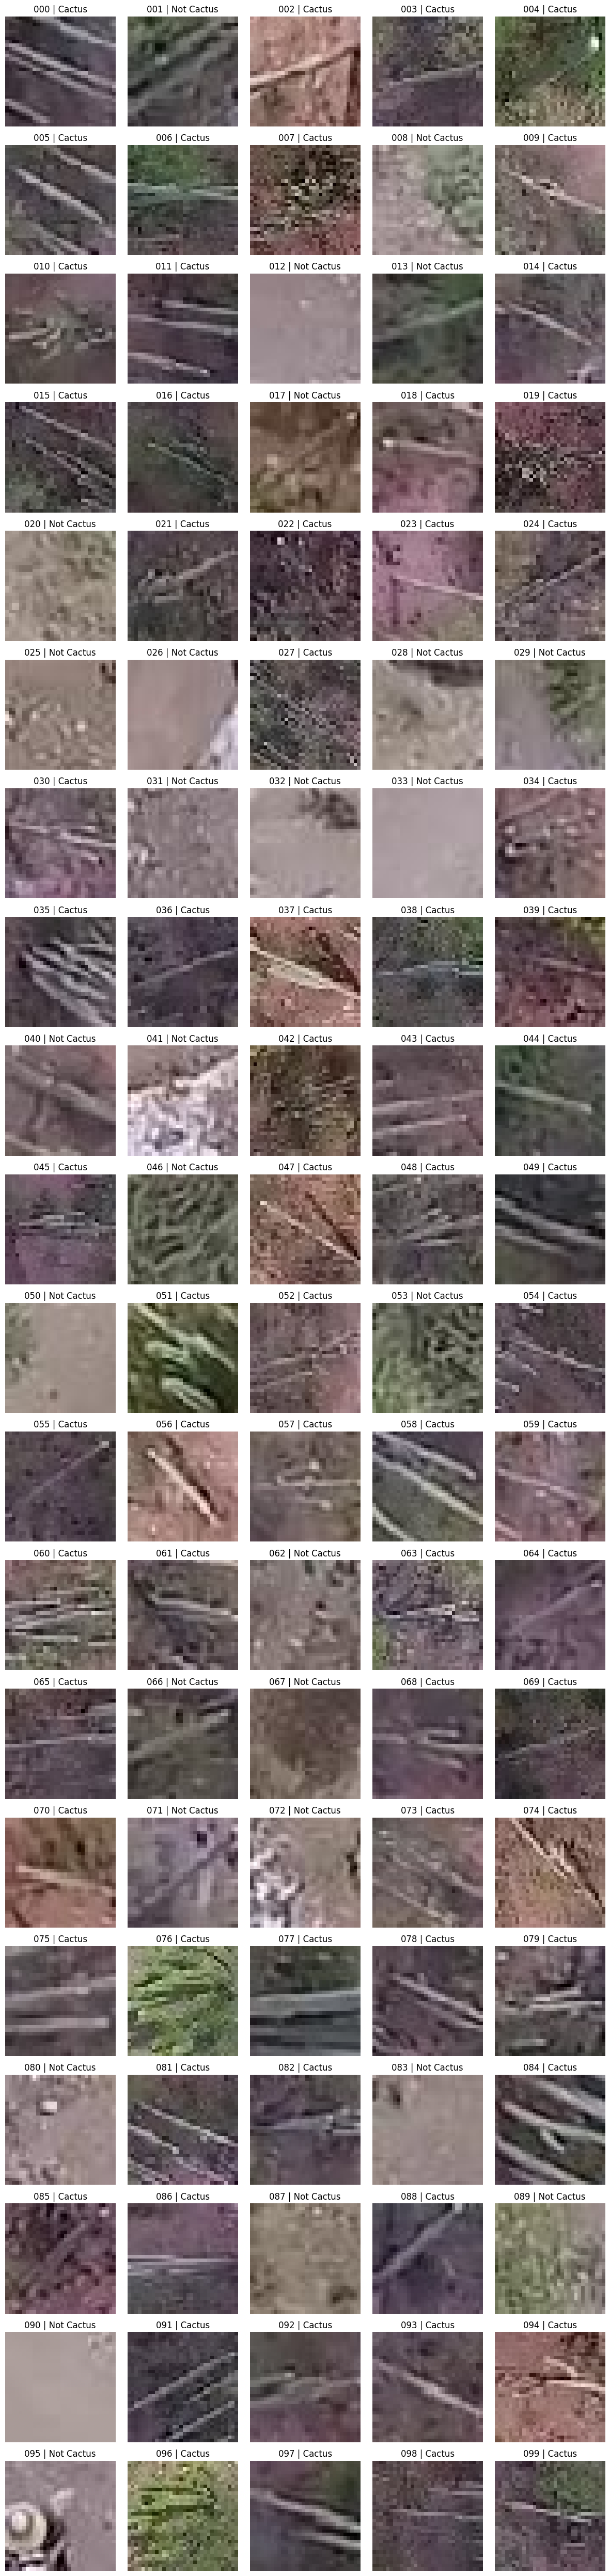

In [28]:
import matplotlib.pyplot as plt

# Create a figure with 4 rows and 5 columns
fig, axes = plt.subplots(20, 5, figsize=(12, 50))
test_data = CactusDataset(TEST_ANNO_FILE, TEST_IMG_DIR, transform=None)
# Iterate over the first 20 images in the dataset
for i in range(100):
    # Get the image and label
    image = test_data[i][0]
    label = predictions[i]

    # Convert the image tensor to numpy array and transpose it
    image = image.numpy().transpose((1, 2, 0))

    # Get the class name based on the label
    class_name = f'{i:03d} | ' + ('Cactus' if label == 1 else 'Not Cactus')

    # Get the corresponding axis in the subplot grid
    ax = axes[i // 5, i % 5]

    # Display the image with its label as the title
    ax.imshow(image)
    ax.set_title(class_name)
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


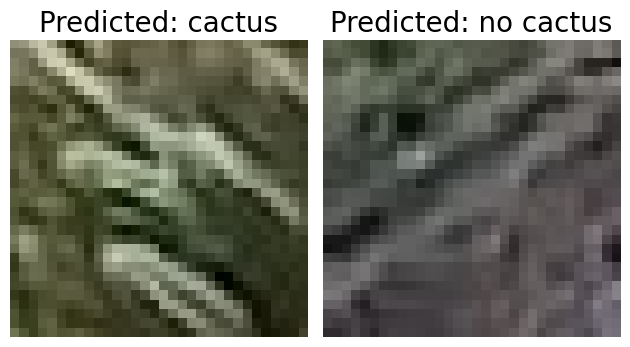

In [32]:
import matplotlib.pyplot as plt

# Plot test_data[51]
plt.subplot(1, 2, 1)
plt.imshow(test_data[51][0].permute(1, 2, 0))
plt.title('Predicted: cactus', fontsize=20)
plt.axis('off')

# Plot test_data[1]
plt.subplot(1, 2, 2)
plt.imshow(test_data[1][0].permute(1, 2, 0))
plt.title('Predicted: no cactus', fontsize=20)
plt.axis('off')

plt.tight_layout()
plt.show()
